# Semantic Localizer Lab

`Author:  Sara Popham, Neuroscience PhD student in the Gallant Lab at UC Berkeley`

`Adapted from a previous lab created by former Gallant Lab graduate students (Anwar Nuñez-Elizalde & Natalia Bilenko) for the UC Berkeley Neuroscience Boot Camp.`

### In this lab we will be looking at how different categories of objects are represented in human visual cortex.

Higher visual cortex is known to process semantic features or categories that are present in visual stimuli. Neuroimaging experiments have identified several cortical regions that selectively respond to particular semantic categories. In other words, these areas are more highly activated when the subject is shown the preferred stimulus category than when the subject is shown any other category of visual stimulus. Two of the most well known category-selective regions are the fusiform face area ([FFA](https://en.wikipedia.org/wiki/Fusiform_face_area)), which responds selectively to images of faces, and the parahippocampal place area ([PPA](https://en.wikipedia.org/wiki/Parahippocampal_gyrus#Scene_recognition)), which responds selectively to images of places. In most fMRI experiments, these regions are identified by showing a constrained set of preferred and nonpreferred stimuli, known as a localizer, to the subject. The category-selective region is defined as the region of high brain activation to preferred stimuli contrasted with nonpreferred stimuli. This method is somewhat limited, since only a small number of categories can be tested at a time. In this lab, we will examine selectivity for faces and places using a traditional category selectivity localizer.

Here, you will build a simple regression model that describes the brain activity in response to static images belonging to two semantic categories: faces and places. The subjects viewed images of faces, places, body parts, objects, and scrambled objects, arranged in blocks of 20 images, while undergoing fMRI. For this lab you will only be looking at responses to two categories of images: faces and places.

In [1]:
## Import necessary functions
from os.path import join as pjoin
import numpy as np
from matplotlib.pyplot import plot, figure, xlabel, ylabel
%matplotlib inline
import scipy.stats
import scipy.io as sio

## This is a file that was written specifically for this
import utils

Loading the semantic localizer data is fairly straightforward with `numpy`.

In [2]:
data_dir = 'data/' # This is the directory with all data for this lab, we will use this variable multiple times

In [3]:
sub_data = np.load(pjoin(data_dir, 'subj1_semloc_data.npy'))

First we will look at the shape of the data we are dealing with.  The first number will be the number of timepoints, and the second number is the total number of cortical voxels.

In [4]:
print(sub_data.shape)

(720, 29324)


#### How many timepoints and voxels are there?

Before doing any analysis, we will do a quick visual inspection of the data.

The next two cells will find the mean timecourse of the whole brain, and then plot that value with respect to time during the experiment.

It is common to look at the shape of the matrices after you perform operations on them to ensure that you have done what you expected to do.  Fill out the axis that we want to take the mean across, and then make sure that the data is the shape that you expect it to be.

In [5]:
#sub_timecourse = sub_data.mean(axis=???) # Recall python is zero indexed, and we want the mean across all voxels
sub_timecourse = sub_data.mean(axis=1) # Recall python is zero indexed, and we want the mean across all voxels
print(sub_timecourse.shape)

(720,)


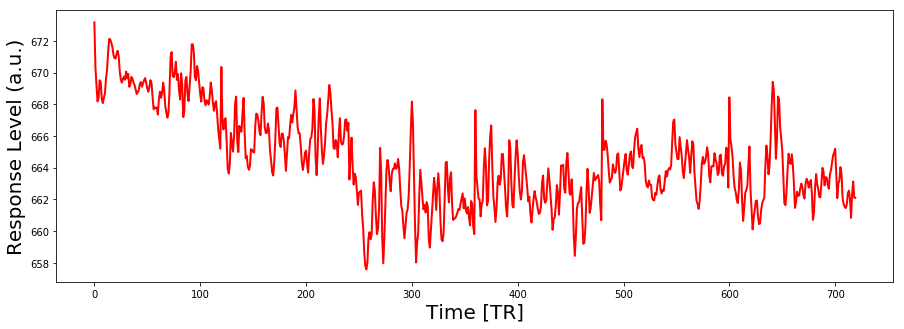

In [6]:
fontsize = 20
fig = figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
_ = ax.plot(sub_timecourse, linewidth=2, color='r')
_ = xlabel('Time [TR]', fontsize=fontsize)
_ = ylabel('Response Level (a.u.)', fontsize=fontsize)

As you can see here, the y-axis for response level is "arbitrary units" (a.u.), and thus the raw values are not interpretable.  This is part of why we typically z-score the voxel responses through time.  We will do this later on in the notebook.

Next, we will look at the average response across the brain, instead of through time.  However, we just have voxel indices right now, instead of the 3-dimensional volume that we recorded from on the fMRI scanner.  This data has been "masked" and we can unmask it by loading the cortical mask and re-organizing the data.

In [7]:
sub_mask = np.load(pjoin(data_dir, 'subj1_corticalmask.npy'))
print(sub_mask.shape)

(32, 100, 100)


Above is the shape of the original volume that we measured.  The `sub_mask` array is filled with True/False values indicating whether that location is a cortical voxel or not.  We can plot this mask one slice at a time to see the shape of the mask using the function `draw_slices` from our `utils.py` file that we imported earlier. 

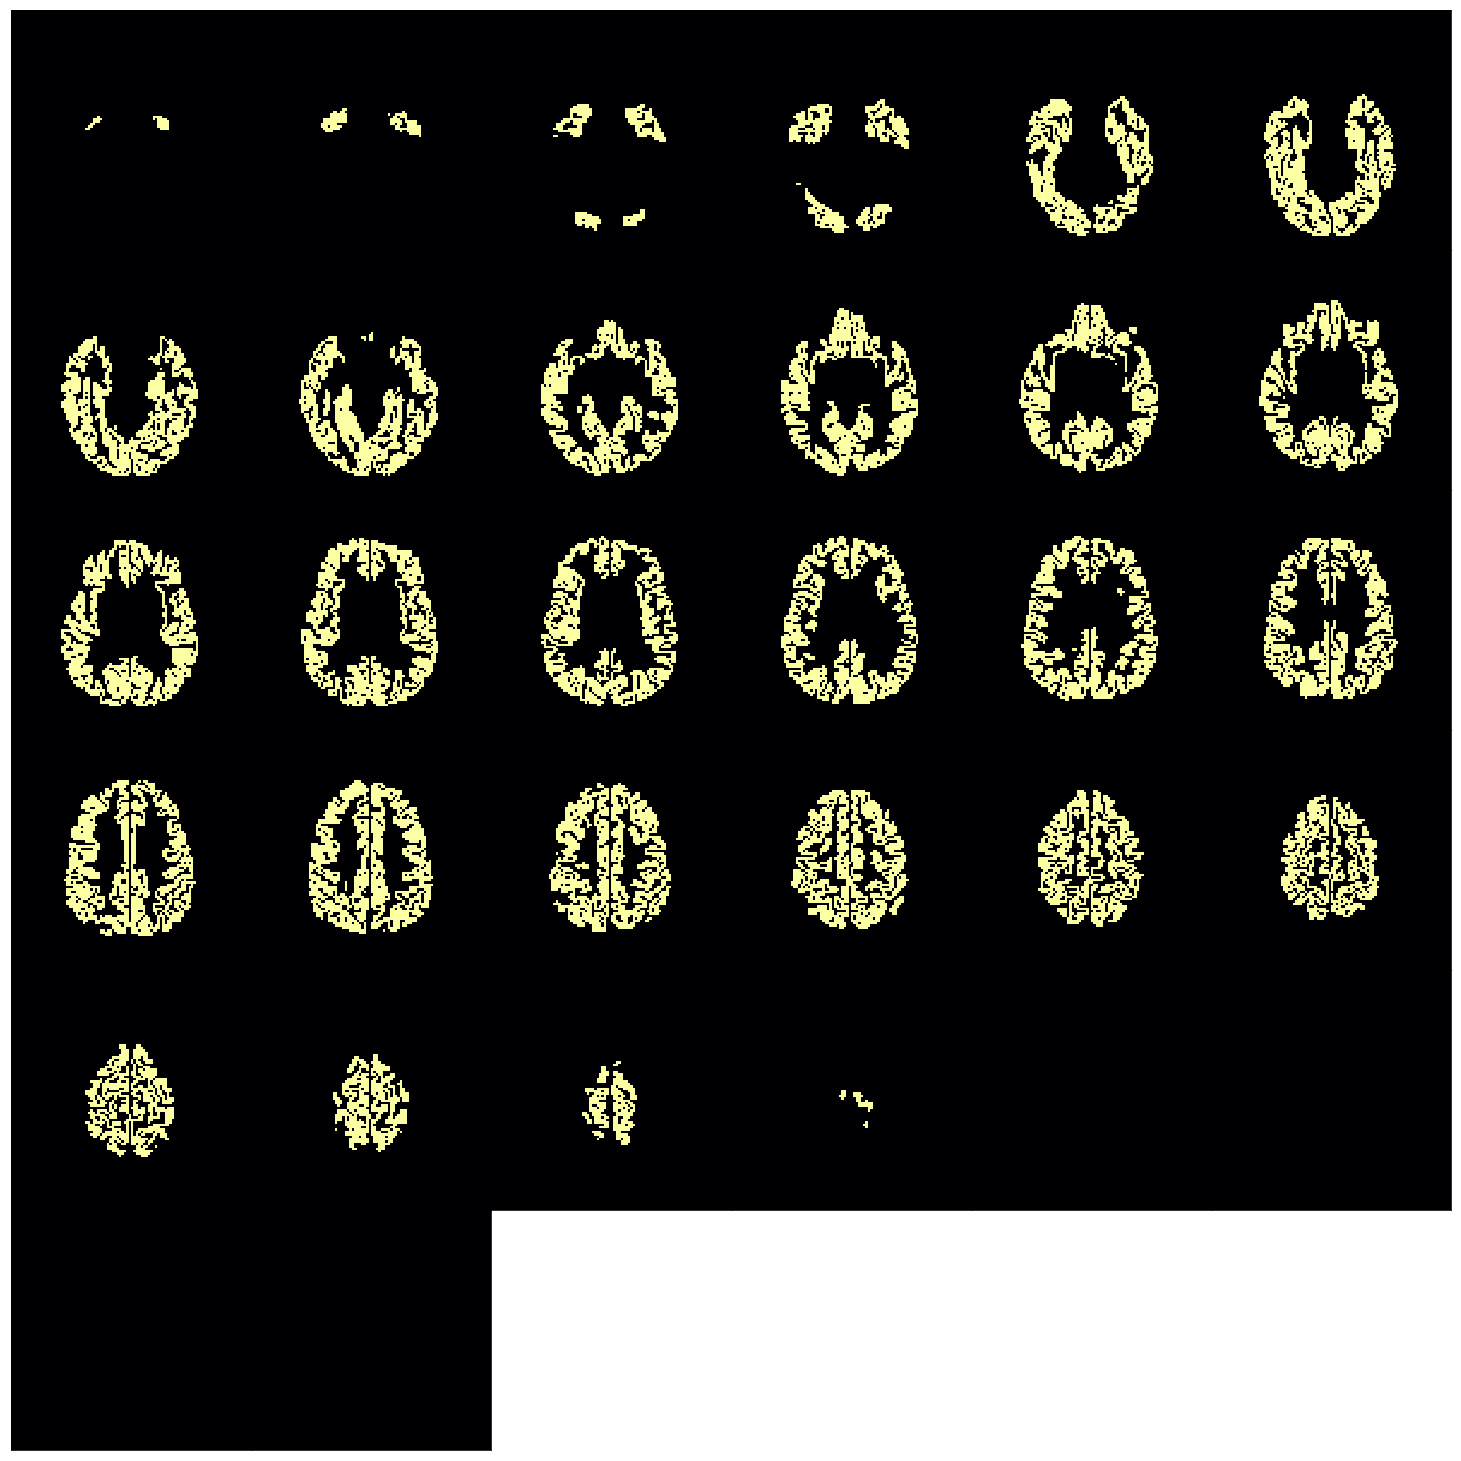

In [8]:
__ = utils.draw_slices(sub_mask)

Now we will take the average data across time and then place it back into the mask.  Again, fill in the axis that the mean will be taken across and check the shape of the resulting array to make sure you have done this correctly.

In [9]:
#mean_data = sub_data.mean(axis=???) # Recall python is zero indexed, and we want the mean across time
mean_data = sub_data.mean(axis=0) # Recall python is zero indexed, and we want the mean across time
print(mean_data.shape)

(29324,)


(32, 100, 100)


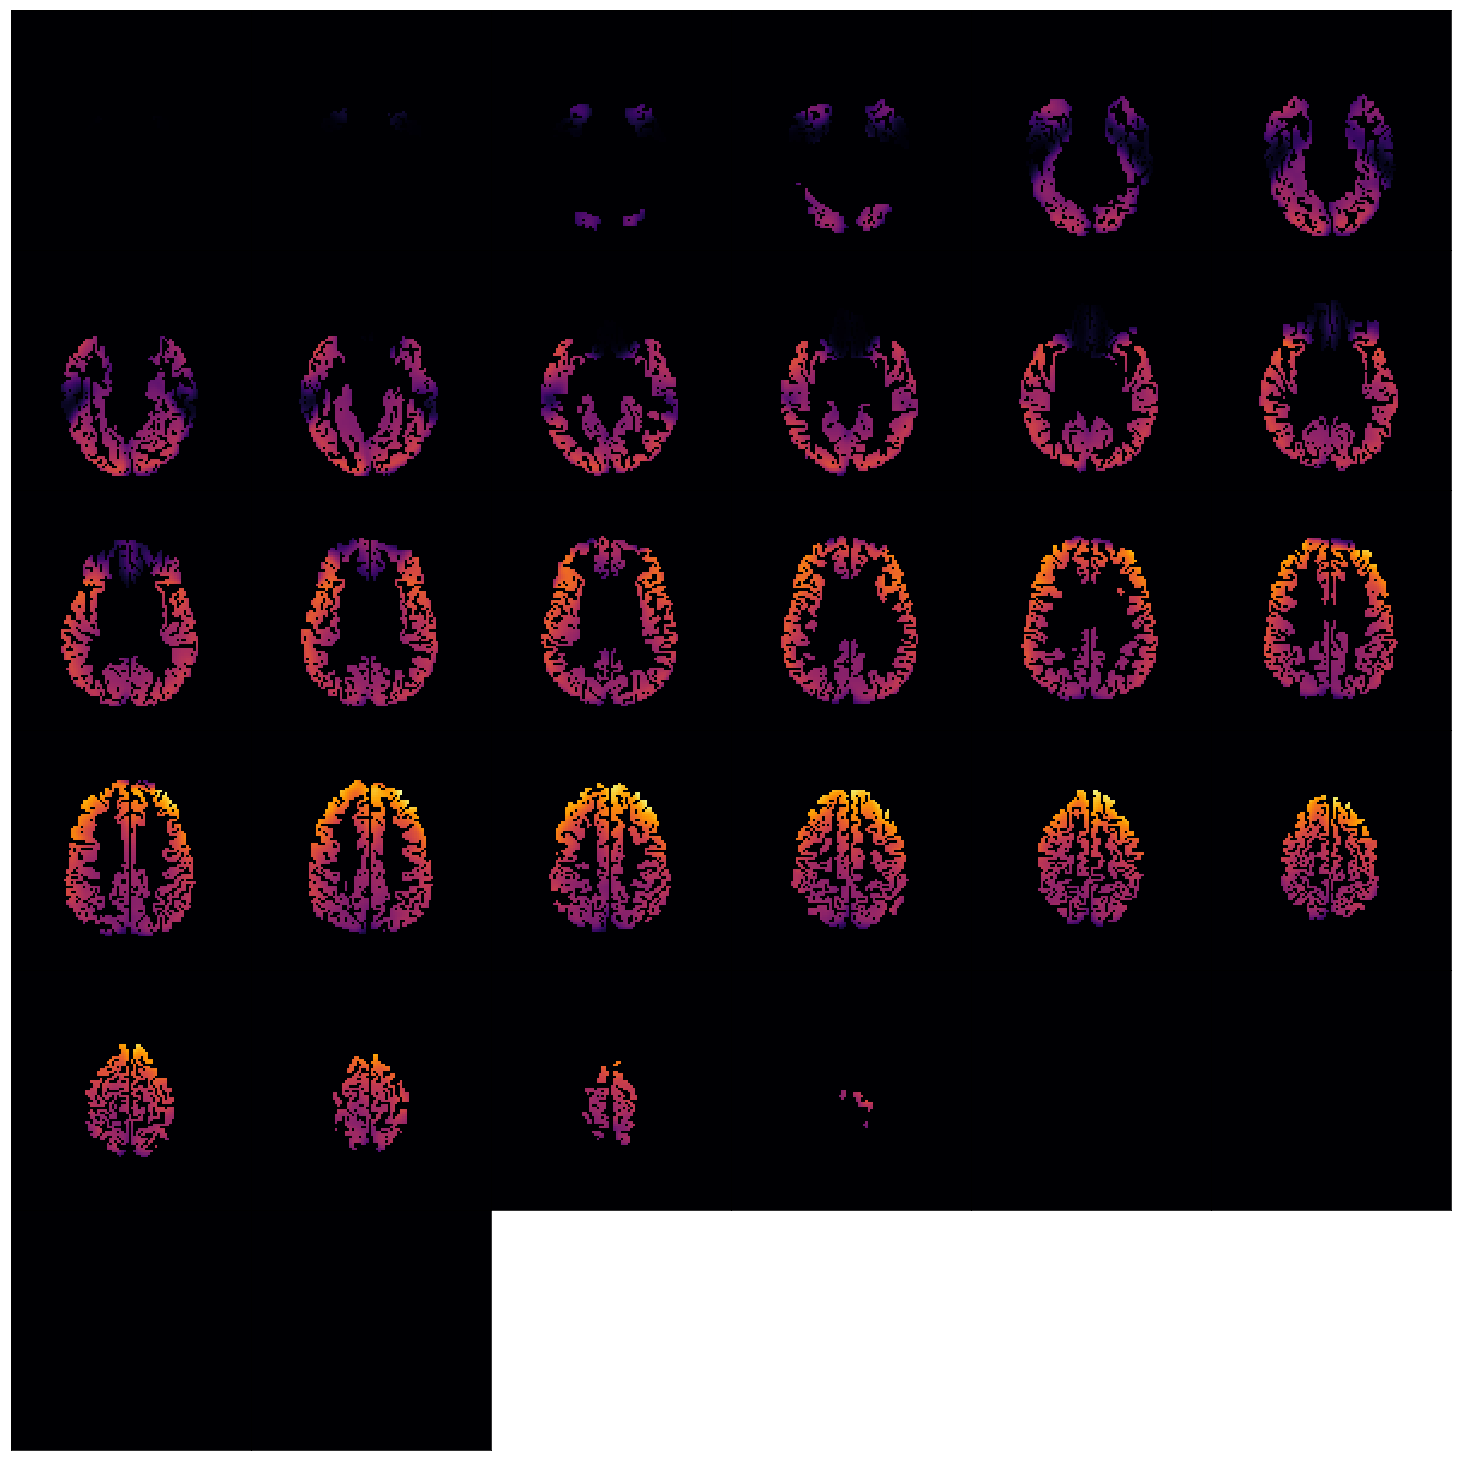

In [10]:
sub_vol = np.zeros(sub_mask.shape)  # Make an empty volume to hold the data 
sub_vol[sub_mask] = mean_data       # Get the voxels from the time point
__ = utils.draw_slices(sub_vol)     # View the data
print(sub_vol.shape)

#### Do you see any differences between the shape of the brain slices here and the slices in the mask?  (Hint: Look at the first few slices)

There are many imperfections with respect to how fMRI measures signals, and one of them is illustrated in the above plot.  You can see that the mean signal level is quite different across the surface of the brain.  This has to do with the variability of magnetic properties across the head.  This problem can even cause signal to not be present in large parts of the brain, referred to as "dropout" regions.  In particular, this is quite bad in orbitofrontal cortex (OFC) and parts of the temporal lobe with most sequences.  This is because of the large cavities in your head like ear canals and your nose.  Using different sequences on the scanner can help with this problem but there are always tradeoffs, so you have to make tough decisions based on your particular experiment and regions of interest.

## Let's analyze the data!

We will examine the responses for two experimental conditions frequently studied in literature: images of **faces** and **places**.

We will load in data about the stimulus so that we know which stimuli were shown at each point in the timecourses that we have.  From this, we will construct the indices for face, place, and object stimuli.

In [11]:
seqfile = pjoin(data_dir, "semCatLocParams.mat")   # Python can even handle MATLAB files!
seqdata = sio.loadmat(seqfile)
print(seqdata['runBlockInds'])
print(seqdata['runBlockInds'].shape)
print('TRs per block', seqdata['trsPerBlock'][0][0])
print('Stimulus categories:', [str(t[0]) for t in seqdata['catNames'][0]])

[[2 3 1 5 4 0 3 2 5 1 4 0]
 [3 4 5 1 2 0 3 4 1 5 2 0]
 [4 1 2 5 3 0 5 2 4 3 1 0]]
(3, 12)
('TRs per block', 10)
('Stimulus categories:', ['body', 'faces', 'object', 'places', 'scrambled'])


Now we will create the stimulus sequence based on the parameters.  We will repeat the indices for the categories as many times as are needed based on `"trsPerBlock"` so that we eventually have a sequence of stimulus information that is as long as the timecourse that we have been working with for the brain data.

In [12]:
# Repeat the indices as many times as is necessary to get the full sequence of stimuli
stimseq = np.repeat(np.hstack(seqdata["runBlockInds"]), seqdata["trsPerBlock"][0][0])

# We repeated the stimulus twice to get better response signal
stimseq = np.hstack([stimseq, stimseq]) 

# There are five categories in the stimulus set, 
# but we are interested in faces and places in particular.
stims = [1,2,3,4,5] 
stimnames = list(map(lambda v:str(v[0]), seqdata["catNames"][0]))
seqmat = np.zeros((len(stimseq), len(stims)))
for si in stims:
    seqmat[:,stims.index(si)] = stimseq==si

nT = seqmat.shape[0] # Number of timepoints
nF = seqmat.shape[1] # Number of features
print(stimseq.shape)
print(seqmat.shape, stimnames)

(720,)
((720, 5), ['body', 'faces', 'object', 'places', 'scrambled'])


We only will be working with the faces and places stimuli in this notebook.  We will still model the brain responses to the other stimuli, but we will not look at the weight maps associated with them.  Here, we get the face and place indices in the stimulus matrix for later use.

In [13]:
sstimseq = np.hstack([[0,0], stimseq[:-2]])
faceidx = stimnames.index('faces')+1
plidx = stimnames.index('places')+1
print(faceidx, plidx)

(2, 4)


Next, we need to build delayed stimulus vectors, because the BOLD response is slow.  You will need to delay and copy the stimulus to account for response hemodynamics. The fMRI response is slow and can last up to 12-20 seconds after the stimulus of interest. Since the scanner records a response every 2 seconds, you will be modeling the fMRI response as a function of seeing a face 4 seconds ago, seeing a face 6 seconds ago, and seeing a face 8 seconds ago. Each of these features will be treated separately during the regression.

First we're going to define the delays (in samples, or TRs) that we want to include.

In [14]:
delays = [2,3,4]
nD = len(delays)
print(nD)

3


Next we create a new blank matrix to hold the delayed stimuli.

In [15]:
deltrn_feats = np.zeros((nT, nD*nF)) 
print(deltrn_feats.shape)

(720, 15)


Finally we need to fill in the delayed stimulus matrices with the appropriate stimuli

In [16]:
for di,d in enumerate(delays):
    ## d is the delay (2, 3, or 4), and di is the index of the delay (0, 1, or 2)
    ## Copy the appropriate portion of seqmat into deltrn_feats for each delay
    deltrn_feats[d:,(nF*di):(nF*(di+1))] = seqmat[:-d]
print(deltrn_feats.shape, seqmat.shape)

((720, 15), (720, 5))


Next we need to Z-score our feature vectors.  We will also be Z-scoring our brain data, so we will write a function to do that. Each column of the zscored matrix should be like the original data, but have mean 0.0 and standard deviation 1.0.

Recall the zscore function is:

$$f(x_i) = \frac{(x_i - \bar{x})}{SD(x)}$$

where $x$ is a vector, $x_i$ is an element of that vector, $\bar{x}$ is the mean of the vector, and $SD(x)$ is the standard deviation.

In the cell below, fill in the functions that you need in order to complete the function.

In [17]:
def zscore(data, axis=0):
    #zs_data = (data - data.???(axis)) / data.???(axis)
    zs_data = (data - data.mean(axis)) / data.std(axis)
    return zs_data

Create a new matrix called ``zdeltrn`` that is the same size as ``deltrn_feats`` (1200x6), but is zscored.

In [18]:
zdeltrn = zscore(deltrn_feats)
print(zdeltrn.shape)

(720, 15)


We will also z-score the voxel responses and also replace NaNs with 0's:


In [19]:
sub_zdata = np.nan_to_num(zscore(sub_data))
print(sub_zdata.shape)

(720, 29324)


Finally, we will use linear regression to model the relationship between stimulus and response for each voxel. We will use a simple regression procedure called ordinary least squares (OLS). We will obtain regression weights for each voxel that will quantify how much that voxel's response is driven by each semantic category. The weights can be compared across voxels or mapped onto the brain.

In [20]:
sub_wts, sub_res, sub_rank, sub_sing = np.linalg.lstsq(zdeltrn, sub_zdata, rcond=0.0)
print(sub_wts.shape)

(15, 29324)


Let's manipulate the weight matrix for convenience. 

In [21]:
sub_udwts = np.zeros((len(stims), len(delays), sub_wts.shape[1]))
for vox in range(sub_wts.shape[1]):
    sub_udwts[:,:,vox] = sub_wts[:,vox].reshape((len(stims), len(delays)), order="F")
print(sub_udwts.shape)

(5, 3, 29324)


#### What does each dimension of ``sub_udwts`` represent?

For simplicity and speed, we will average the weights for three delays.


In [22]:
sub_mwts = sub_udwts.mean(1) # take average across delays
sub_face_wts = sub_mwts[faceidx-1] # face weights
sub_place_wts = sub_mwts[plidx-1]  # place weights
print(sub_mwts.shape, sub_face_wts.shape, sub_place_wts.shape)

((5, 29324), (29324,), (29324,))


Last, we will onvert the mean **face** weights into a volume using the mask again and plot them.

(32, 100, 100)


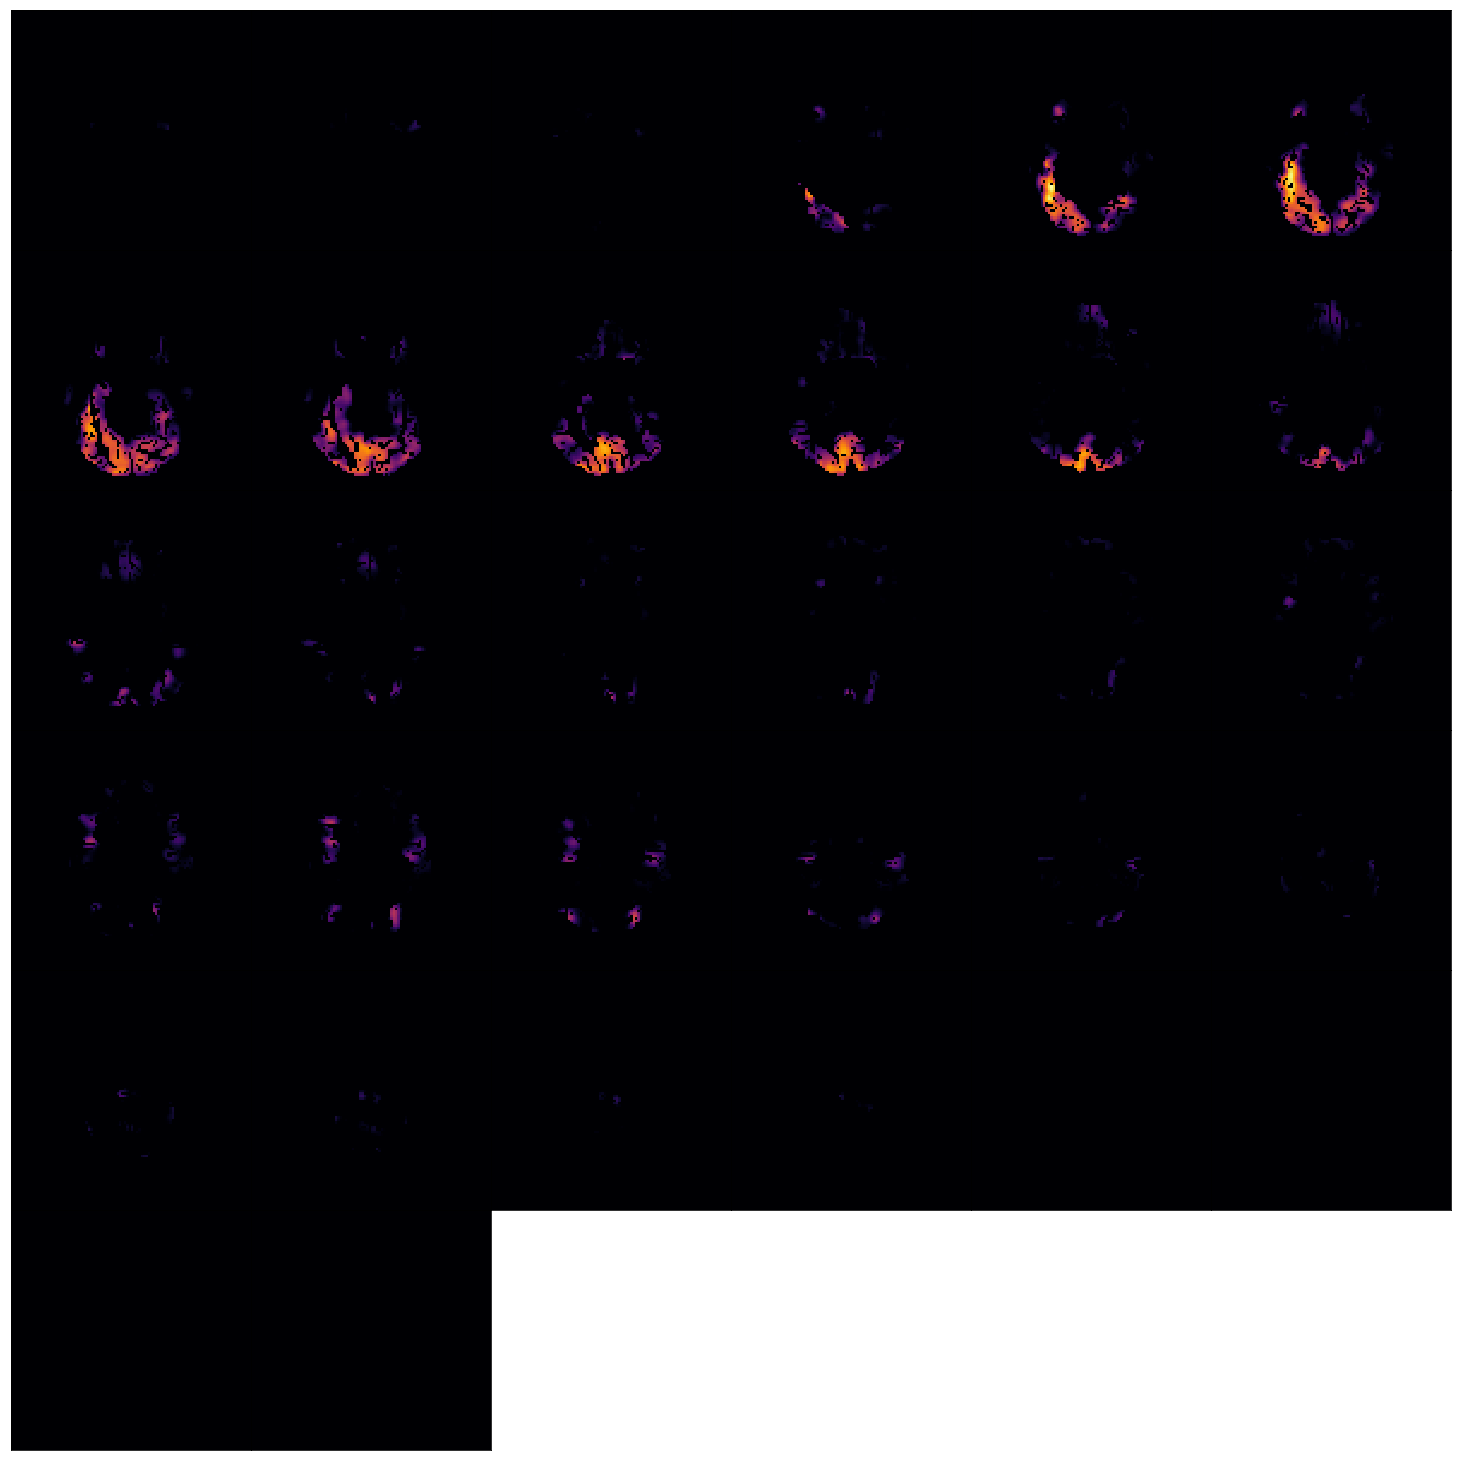

In [24]:
sub_face_wts_vol = np.zeros(sub_mask.shape)
sub_face_wts_vol[sub_mask] = sub_face_wts
__ = utils.draw_slices(sub_face_wts_vol, tmin=0)
print(sub_face_wts_vol.shape)

And we can do the same for the **place** weights.

(32, 100, 100)


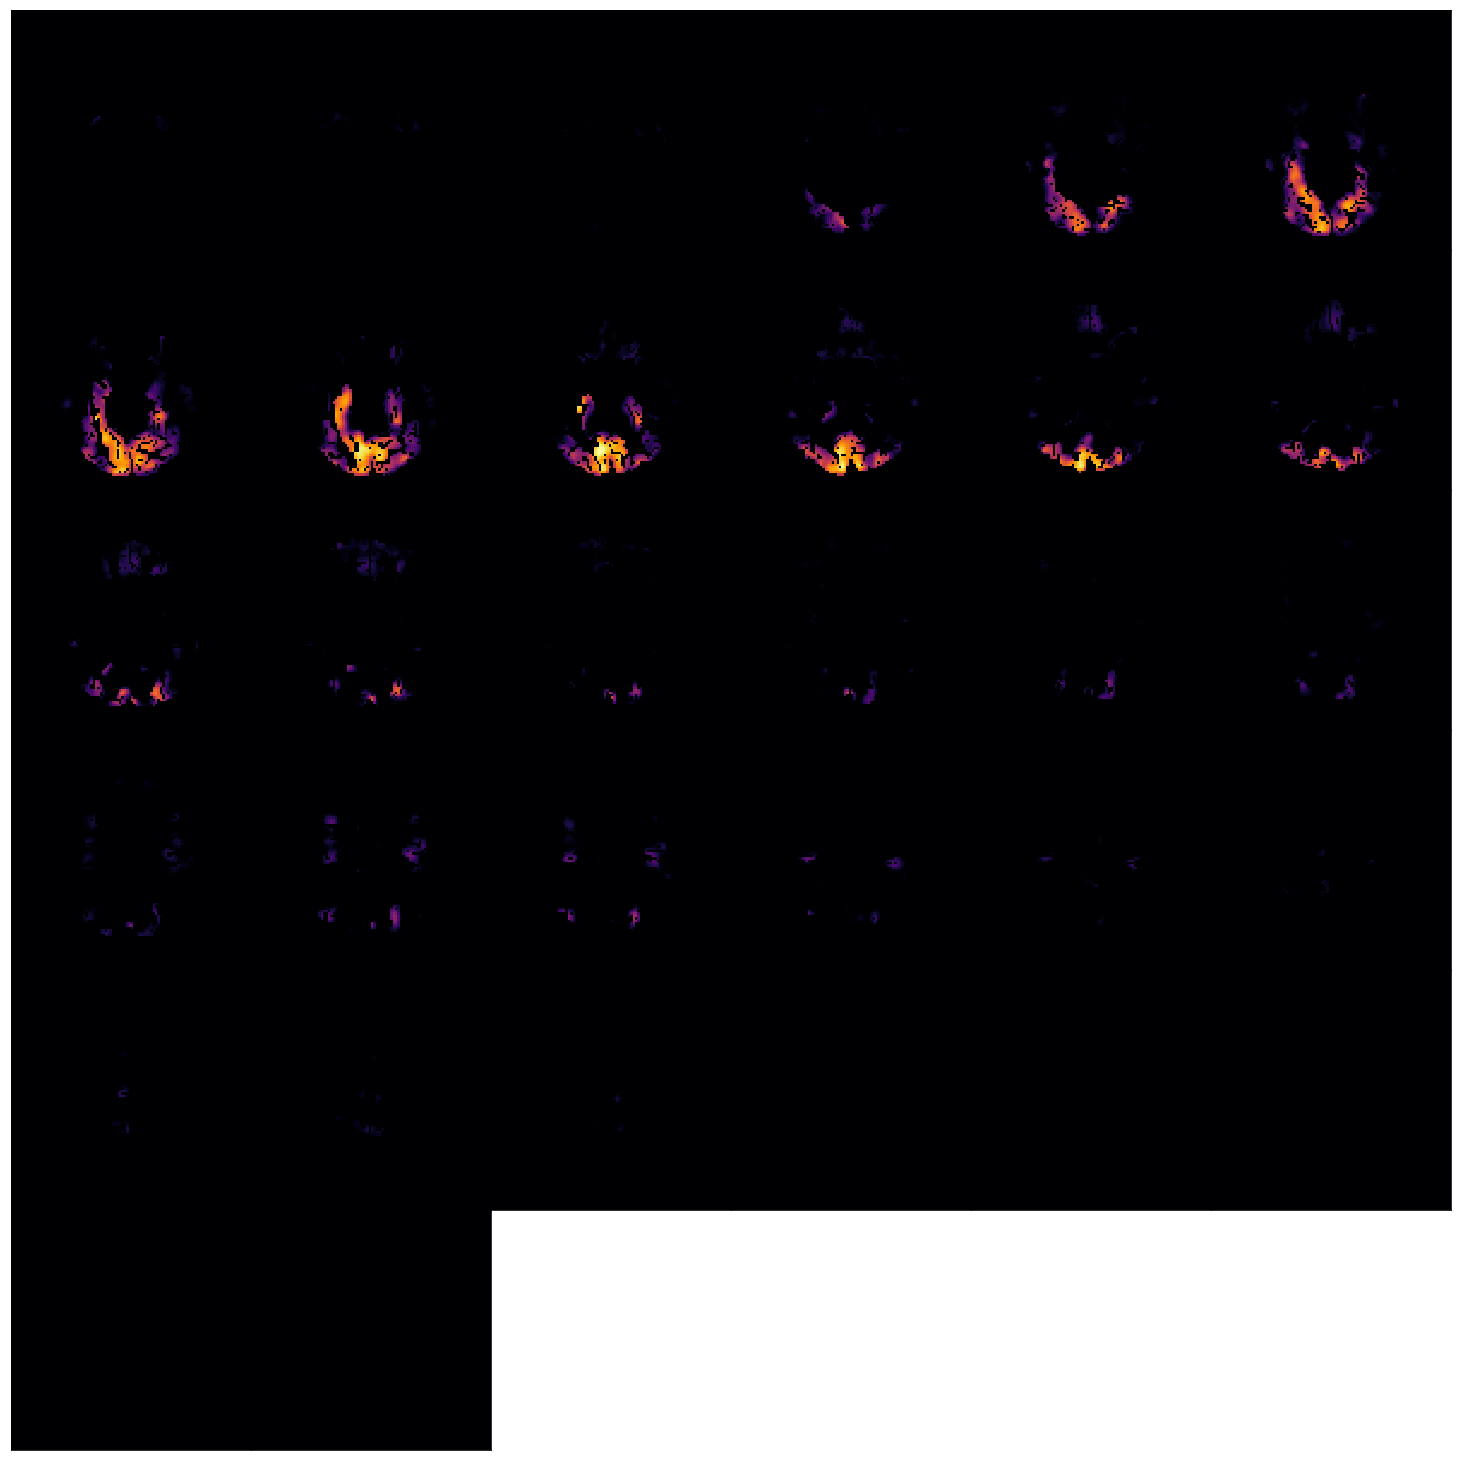

In [25]:
sub_place_wts_vol = np.zeros(sub_mask.shape)
sub_place_wts_vol[sub_mask] = sub_place_wts
__ = utils.draw_slices(sub_place_wts_vol, tmin=0)
print(sub_place_wts_vol.shape)

#### What are some similarities and differences that you see between these two weight maps?  To compare them more easily, you might want to right click on each image and open it in a new tab, then flip back and forth between the two tabs.

## A More Complex Dataset

In this localizer task, we only looked at the responses to 5 categories of objects, but there are many more stimuli that we might be interested in.  To fully model this, we ran another experiment in which subjects watched movie clips and every object that appeared or action that occurred in the movie was labeled.  In this dataset we had **1705** features that we modeled the responses to, instead of the 5 shown in this localizer.

We then modeled the brain responses as a combination of those features with delays, almost exactly as was shown here.  The only major difference is that we used [Ridge Regression](https://en.wikipedia.org/wiki/Tikhonov_regularization) instead of [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) because Ridge helps to avoid overfitting, which can be a problem when you have a large number of features in your model.  (This is not particularly important to this tutorial though.)

The output of this model was 1705 weight maps like what you saw above for faces and places, but for a much wider variety of concepts.  Our lab published a [paper on this in 2012](https://doi.org/10.1016/j.neuron.2012.10.014), and we have shared a [brain viewer](http://gallantlab.org/brainviewer/huthetal2012/) in which you can explore the results.

This [brain viewer](http://gallantlab.org/brainviewer/huthetal2012/) was created using [pycortex](https://github.com/gallantlab/pycortex), which is a software package developed in the Gallant Lab by James Gao.

Take some time to explore the [brain viewer](http://gallantlab.org/brainviewer/huthetal2012/), and answer the questions below.  Some instructions should pop up when you click that link, but here are the important things:

* You can switch between datasets using a panel at the top of the screen.
* Clicking on a category on the right pane will show its weight map on the brain.
* You can inflate and flatten the brain using the slider on the bottom of the left pane.

#### Go to the top of the screen and turn off the ROI labels by clicking the box.  Then, using the categories in the right pane on the screen, see if you can determine which ROIs (outlined in white on the brain) are the FFA and PPA.  What was your strategy for this?  If you turn the labels back on, you can check if you were correct.  Did you find them correctly?

#### Similar to the FFA and PPA, there is a visual area that is thought to be specialized for reading text called the ["Visual Word Form Area" (VWFA)](https://en.wikipedia.org/wiki/Visual_word_form_area).  The VWFA is located just lateral to the FFA.  We do not have that ROI drawn on this brain, but see if you can localize it using another of these weight maps.  Do you think you found it?

#### Did you find anything else particularly intresting in the dataset?  Share it here!